### Escenario tipo archipielago

Elegí una configuración tipo archipiélago varias islas (clusters) de ciudades, separadas por huecos, para que el TSP tenga decisiones interesantes entre saltos inter-cluster y recorridos locales. Es un patrón común en logística y hace que el GA deba equilibrar explotación (ordenar dentro de una isla) y exploración (en qué orden visitar islas).

In [1]:
import os, math, random, time, textwrap
from dataclasses import dataclass
from typing import List, Tuple
import matplotlib.pyplot as plt
from distance_table import DistanceTable


RANDOM_SEED = 42
random.seed(RANDOM_SEED)

DATA_INPUT_DIR = "../data/input"
DATA_EXPECTED_DIR = "../data/expected"
OUTPUT_DIR = "output/archipelago120"

os.makedirs(DATA_INPUT_DIR, exist_ok=True)
os.makedirs(DATA_EXPECTED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

INSTANCE_NAME = "archipelago120"
TSP_PATH = os.path.join(DATA_INPUT_DIR, f"{INSTANCE_NAME}.tsp")


In [2]:
def write_tsplib_euc2d(path: str, name: str, coords: List[Tuple[int, float, float]]):
    """
    Escribe un archivo TSPLIB EUC_2D.
    coords: lista de tuplas (id, x, y) con IDs 1-based.
    """
    lines = []
    lines.append(f"NAME: {name}")
    lines.append("TYPE: TSP")
    lines.append("COMMENT: Invented archipelago instance")
    lines.append(f"DIMENSION: {len(coords)}")
    lines.append("EDGE_WEIGHT_TYPE: EUC_2D")
    lines.append("NODE_COORD_SECTION")
    for node_id, x, y in coords:
        lines.append(f"{node_id} {x:.3f} {y:.3f}")
    lines.append("EOF\n")
    with open(path, "w") as f:
        f.write("\n".join(lines))

def read_tsplib_coords(path: str) -> List[Tuple[int, float, float]]:
    """
    Lee coordenadas (id, x, y) desde un .tsp (TSPLIB).
    """
    coords = []
    with open(path, "r") as f:
        in_section = False
        for line in f:
            line = line.strip()
            if line == "NODE_COORD_SECTION":
                in_section = True
                continue
            if line == "EOF":
                break
            if in_section and line:
                parts = line.split()
                if len(parts) >= 3:
                    node_id = int(parts[0])
                    x = float(parts[1])
                    y = float(parts[2])
                    coords.append((node_id, x, y))
    return coords


### Generación del escenario archipelago120

In [3]:
def generate_archipelago(
    total_cities: int = 120,
    k_islands: int = 6,
    island_size_range=(15, 25),
    sigma_within=25.0,
    min_center_spacing=200.0,
    plane_size=1000.0,
    seed=RANDOM_SEED,
):
    """
    Genera un conjunto de ciudades en clusters
    - total_cities: N total de ciudades (50..200)
    - k_islands: número de islas (clusters)
    - island_size_range: rango de ciudades por isla (min, max)
    - sigma_within: dispersión dentro de la isla
    - min_center_spacing: separación mínima entre centros
    - plane_size: tamaño del plano [0, plane_size]
    """
    rnd = random.Random(seed)

    # Elegir centros bien separados
    centers = []
    attempts = 0
    while len(centers) < k_islands and attempts < 10000:
        cx = rnd.uniform(100, plane_size - 100)
        cy = rnd.uniform(100, plane_size - 100)
        if all(math.hypot(cx - ox, cy - oy) >= min_center_spacing for (ox, oy) in centers):
            centers.append((cx, cy))
        attempts += 1
    if len(centers) < k_islands:
        raise RuntimeError("No pude ubicar los centros con la separación mínima.")

    # Distribuir tamaños por isla y ajustar a total_cities
    sizes = [rnd.randint(*island_size_range) for _ in range(k_islands)]
    scale = total_cities / sum(sizes)
    sizes = [max(5, int(round(s * scale))) for s in sizes]

    # Ajuste fino si nos pasamos o faltan
    diff = total_cities - sum(sizes)
    idx = 0
    while diff != 0:
        if diff > 0:
            sizes[idx % k_islands] += 1
            diff -= 1
        else:
            if sizes[idx % k_islands] > 5:
                sizes[idx % k_islands] -= 1
                diff += 1
        idx += 1

    # Generar puntos alrededor de cada centro
    coords = []
    next_id = 1
    for (cx, cy), n_k in zip(centers, sizes):
        for _ in range(n_k):
            # desplazamiento gaussiano 2D
            dx = rnd.gauss(0, sigma_within)
            dy = rnd.gauss(0, sigma_within)
            x = min(max(0.0, cx + dx), plane_size)
            y = min(max(0.0, cy + dy), plane_size)
            coords.append((next_id, x, y))
            next_id += 1

    # sanity check
    assert len(coords) == total_cities
    return coords, centers, sizes

# Generar y escribir el escenario TSPLIB
coords, centers, sizes = generate_archipelago(
    total_cities=120,
    k_islands=6,
    island_size_range=(15, 25),
    sigma_within=25.0,
    min_center_spacing=220.0,
    plane_size=1000.0,
    seed=RANDOM_SEED,
)
write_tsplib_euc2d(TSP_PATH, INSTANCE_NAME, coords)

print(f"Generado: {TSP_PATH}")
print(f"Islas: {len(sizes)} | Ciudades por isla: {sizes} | Total: {sum(sizes)}")
print("Primeras 5 líneas del .tsp:")
print("--------------------------------")
with open(TSP_PATH, "r") as f:
    for i, line in enumerate(f):
        if i == 12: break
        print(line.rstrip())


Generado: ../data/input\archipelago120.tsp
Islas: 6 | Ciudades por isla: [20, 15, 22, 18, 23, 22] | Total: 120
Primeras 5 líneas del .tsp:
--------------------------------
NAME: archipelago120
TYPE: TSP
COMMENT: Invented archipelago instance
DIMENSION: 120
EDGE_WEIGHT_TYPE: EUC_2D
NODE_COORD_SECTION
1 629.353 104.395
2 614.909 128.884
3 588.760 83.473
4 660.488 115.451
5 627.881 101.820
6 566.170 133.683


### distancias y estructura interna

In [4]:

coords_loaded = read_tsplib_coords(TSP_PATH)

node_list_str = [f"{nid} {x} {y}" for (nid, x, y) in coords_loaded]

distance_table = DistanceTable(node_list_str)

print(distance_table)
print("Primer nodo:", distance_table.nodes[0])
print("Distancia entre nodo 1 y 2:", round(distance_table.get_distance_between_nodes(1, 2), 3))
print("Distancia por índice 0-1:", round(distance_table.get_distance_by_index(0, 1), 3))

DistanceTable with 120 nodes
Primer nodo: (1, 629.353, 104.395)
Distancia entre nodo 1 y 2: 28.431
Distancia por índice 0-1: 28.431


### diseño del algoritmo genetico

In [5]:
# Helpers de ruta 

def route_distance(route: List[int], dist: DistanceTable) -> float:
    total = 0.0
    n = len(route)
    for i in range(n):
        total += dist.get_distance_by_index(route[i], route[(i+1) % n])
    return total

def initial_population(N: int, num_nodes: int) -> List[List[int]]:
    pop = []
    base = list(range(num_nodes))
    for _ in range(N):
        r = base[:]
        random.shuffle(r)
        pop.append(r)
    return pop

def tournament_selection(population, dist_table, k=5):
    selected = random.sample(population, k)
    selected.sort(key=lambda r: route_distance(r, dist_table))
    return selected[0]

def order_crossover(p1: List[int], p2: List[int]) -> List[int]:
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2))
    child = [-1]*n
    # copia segmento de p1
    child[a:b] = p1[a:b]
    # completa con genes de p2 en orden
    pos = b
    for g in p2:
        if g not in child:
            if pos >= n: pos = 0
            child[pos] = g
            pos += 1
    return child

def swap_mutation(route: List[int]) -> List[int]:
    r = route[:]
    i, j = random.sample(range(len(route)), 2)
    r[i], r[j] = r[j], r[i]
    return r

def inversion_mutation(route: List[int]) -> List[int]:
    r = route[:]
    i, j = sorted(random.sample(range(len(route)), 2))
    r[i:j] = reversed(r[i:j])
    return r

def genetic_algorithm(dist_table: DistanceTable, 
                      N=250, maxIter=6000,
                      p_survivors=0.2, p_crossover=0.7, p_mutation=0.15,
                      k_tournament=5,
                      record_every=20,
                      verbose_every=200):
    n = len(dist_table.nodes)
    pop = initial_population(N, n)

    best_route = None
    best_dist = float("inf")
    best_history = []      # (gen, best_dist)
    route_snapshots = []   # (gen, route, dist)

    t0 = time.time()
    for gen in range(1, maxIter+1):
        pop.sort(key=lambda r: route_distance(r, dist_table))
        current_best = pop[0]
        current_dist = route_distance(current_best, dist_table)

        if current_dist < best_dist:
            best_route, best_dist = current_best[:], current_dist

        if gen % record_every == 0:
            best_history.append((gen, best_dist))
            route_snapshots.append((gen, best_route[:], best_dist))

        # Verbose
        if gen % verbose_every == 0:
            print(f"[Gen {gen}] Best = {best_dist:.2f}")

        # Elitismo
        survivors = pop[:int(p_survivors*N)]

        # Cruce
        children = []
        for _ in range(int(p_crossover*N)):
            p1 = tournament_selection(pop, dist_table, k_tournament)
            p2 = tournament_selection(pop, dist_table, k_tournament)
            child = order_crossover(p1, p2)
            children.append(child)

        # Mutación
        mutants = []
        for _ in range(int(p_mutation*N)):
            r = random.choice(pop)
            mutants.append(swap_mutation(r) if random.random() < 0.5 else inversion_mutation(r))

        # Nueva población
        pop = survivors + children + mutants

        # Quitar duplicados
        uniq, seen = [], set()
        for r in pop:
            t = tuple(r)
            if t not in seen:
                seen.add(t)
                uniq.append(r)
        pop = uniq

        # Inmigración si falta población
        while len(pop) < N:
            immigrant = list(range(n))
            random.shuffle(immigrant)
            pop.append(immigrant)

        # Capar si sobra
        if len(pop) > N:
            pop.sort(key=lambda r: route_distance(r, dist_table))
            pop = pop[:N]

    elapsed = time.time() - t0
    return {
        "best_route": best_route,
        "best_dist": best_dist,
        "history": best_history,
        "snapshots": route_snapshots,
        "elapsed": elapsed,
        "params": {
            "N": N, "maxIter": maxIter, "p_survivors": p_survivors,
            "p_crossover": p_crossover, "p_mutation": p_mutation,
            "k_tournament": k_tournament
        }
    }


### Ejecucion del GA

In [6]:
result = genetic_algorithm(
    distance_table,
    N=250,
    maxIter=6000,
    p_survivors=0.2,
    p_crossover=0.7,
    p_mutation=0.15,
    k_tournament=5,
    record_every=20,
    verbose_every=500
)

best_route_idx = result["best_route"]
best_dist = result["best_dist"]
elapsed = result["elapsed"]

print("\n", "-"*20, "RESULTADO GA", "-"*20)
print("Mejor distancia:", round(best_dist, 3))
print("Tiempo (s):", round(elapsed, 2))
print("Primeros 20 índices de la mejor ruta (0-based):", best_route_idx[:20])


[Gen 500] Best = 4724.43
[Gen 1000] Best = 3668.86
[Gen 1500] Best = 3545.49
[Gen 2000] Best = 3497.61
[Gen 2500] Best = 3484.10
[Gen 3000] Best = 3475.71
[Gen 3500] Best = 3475.71
[Gen 4000] Best = 3475.71
[Gen 4500] Best = 3474.12
[Gen 5000] Best = 3474.12
[Gen 5500] Best = 3474.12
[Gen 6000] Best = 3474.12

 -------------------- RESULTADO GA --------------------
Mejor distancia: 3474.118
Tiempo (s): 157.49
Primeros 20 índices de la mejor ruta (0-based): [33, 5, 13, 11, 10, 18, 6, 1, 8, 12, 9, 17, 2, 7, 15, 4, 0, 19, 3, 14]


### Visualizaciones

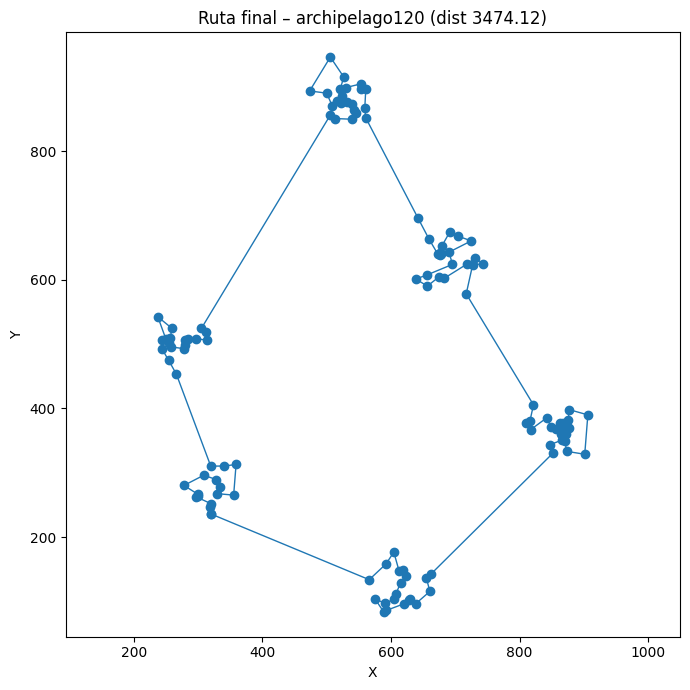

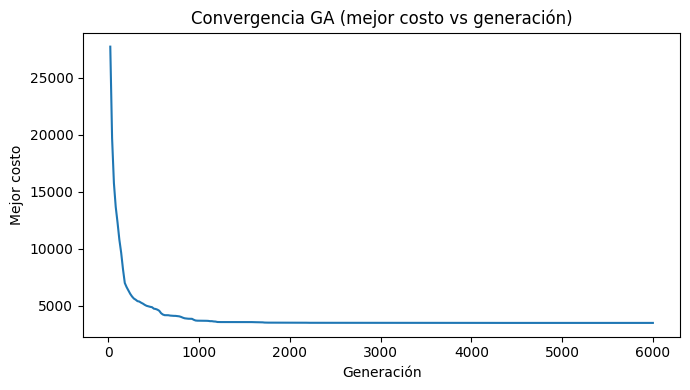

Guardadas figuras en:
 - output/archipelago120\route_best_archipelago120.png
 - output/archipelago120\convergence_archipelago120.png


In [7]:
# Graficar la ruta final
def plot_route(route_idx: List[int], dist_table: DistanceTable, title="Best Route"):
    nodes = dist_table.nodes
    xs = [nodes[i][1] for i in route_idx] + [nodes[route_idx[0]][1]]
    ys = [nodes[i][2] for i in route_idx] + [nodes[route_idx[0]][2]]

    plt.figure(figsize=(7,7))
    plt.plot(xs, ys, marker='o', linewidth=1)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.tight_layout()

def plot_convergence(history):
    gens = [g for g, _ in history]
    vals = [v for _, v in history]
    plt.figure(figsize=(7,4))
    plt.plot(gens, vals)
    plt.title("Convergencia GA (mejor costo vs generación)")
    plt.xlabel("Generación")
    plt.ylabel("Mejor costo")
    plt.tight_layout()

plot_route(best_route_idx, distance_table, 
           title=f"Ruta final – {INSTANCE_NAME} (dist {best_dist:.2f})")
route_png = os.path.join(OUTPUT_DIR, f"route_best_{INSTANCE_NAME}.png")
plt.savefig(route_png, dpi=160)
plt.show()

plot_convergence(result["history"])
conv_png = os.path.join(OUTPUT_DIR, f"convergence_{INSTANCE_NAME}.png")
plt.savefig(conv_png, dpi=160)
plt.show()

print("Guardadas figuras en:")
print(" -", route_png)
print(" -", conv_png)


### Guardar tour y costo en archivo

In [8]:
def write_tsplib_tour(path: str, tour_ids_1based: List[int], name="GA_SOLUTION"):
    lines = []
    lines.append(f"NAME: {name}")
    lines.append("TYPE: TOUR")
    lines.append(f"DIMENSION: {len(tour_ids_1based)}")
    lines.append("TOUR_SECTION")
    lines += [str(i) for i in tour_ids_1based]
    lines.append("-1")
    lines.append("EOF\n")
    with open(path, "w") as f:
        f.write("\n".join(lines))

# Convertir índices 0-based -> IDs 1-based del TSPLIB
route_ids_1based = [distance_table.nodes[i][0] for i in best_route_idx]

# Guardar TOUR y costo
tour_path = os.path.join(OUTPUT_DIR, f"tour_ga_{INSTANCE_NAME}.tour")
write_tsplib_tour(tour_path, route_ids_1based, name=f"{INSTANCE_NAME}_GA")

cost_path = os.path.join(OUTPUT_DIR, f"costo_ga_{INSTANCE_NAME}.txt")
with open(cost_path, "w") as f:
    f.write(f"{best_dist:.6f}\n")

print("Archivos guardados:")
print(" -", tour_path)
print(" -", cost_path)


Archivos guardados:
 - output/archipelago120\tour_ga_archipelago120.tour
 - output/archipelago120\costo_ga_archipelago120.txt


Qué cambiar si quiero otro escenario o tamaño:

En la Celda 6, modifica:

total_cities (entre 50 y 200),

k_islands, sigma_within, min_center_spacing, etc.

Cambia INSTANCE_NAME (Celda 2) si quieres guardar otra instancia y sus salidas por separado.

Ajusta hiperparámetros del GA (Celda 12) según tu tiempo de cómputo.

Entrega esperada de la Parte 1 (para este escenario):

El .ipynb con todo,

data/input/archipelago120.tsp,

output/archipelago120/* con imágenes, tour y costo.

Cuando confirmes que te corre bien esta Parte 1, armamos la Parte 2 en otro notebook autocontenido (formulación exacta tipo DFJ/MTZ, lectura de archipelago120.tsp, construcción del tour, comparación GA vs exacto, etc.).